## In this Regression Example we will look at the basic operations of PyTorch in building a model manually ##

The same aplies for classification problems with one or two things being different (like loss function, etc,.)

#### We are going to study the basic PyTorch operations in this notebook in a step-by-step manner as follows:

1. We shall generate some random data and create a train and test set using the basic numpy library.

2. We will then create a linear regression model using some PyTorch operations but in a very manual way (like you did with the gradient descent exercise).

3. Then we will partially automate the model building process using more PyTorch operations.

4. Finally, we will build the same model using all PyTorch operations.

Through this process you will get a very good a good grasp of the PyTorch basics.

In [1]:
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

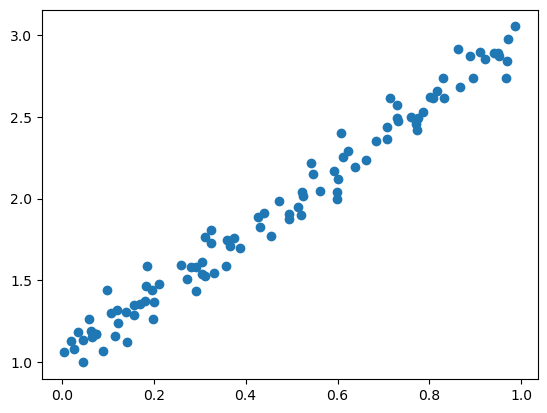

In [2]:
# Data Generation
np.random.seed(42) # for reproducibility
x = np.random.rand(100, 1) # generates 100 random numbers from a uniform distribution between 0 and 1
y = 1 + 2 * x + .1 * np.random.randn(100, 1) # actual data generation

# Shuffles the indices
idx = np.arange(100) # generates an array of indices from 0 to 99
np.random.shuffle(idx) # shuffles the indices

# Uses first 80 random indices for train
train_idx = idx[:80] # selects the first 80 indices
# Uses the remaining indices for validation
val_idx = idx[80:] # selects the remaining indices

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx] # selects the x and y values for the train indices
x_val, y_val = x[val_idx], y[val_idx] # selects the x and y values for the validation indices
plt.scatter(x,y) # plots the data
plt.show() # shows the plot

In [4]:
import torch as torch

In [5]:
# We want to take advantage of Nvidia's GPU processing if a Nvidia GPU is available on the machine
device = 'cuda' if torch.cuda.is_available() else 'cpu' # checks if a GPU is available

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device) # converts the numpy array to a tensor and sends it to the GPU core
y_train_tensor = torch.from_numpy(y_train).float().to(device) # converts the numpy array to a tensor and sends it to the GPU core

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
# torch.FloatTensor — a CPU tensor in this case.
# else, torch.cuda.FloatTensor — a GPU tensor.

print(f"Original data type:{type(x_train)}\nArray converted to tensor:{type(x_train_tensor)}\nIncluding type and location of data:{x_train_tensor.type()}") # prints the type of the original data, the type of the tensor, and the type and location of the tensor

Original data type:<class 'numpy.ndarray'>
Array converted to tensor:<class 'torch.Tensor'>
Including type and location of data:torch.FloatTensor


In [6]:
# FIRST METHOD
# Initializes parameters "w0" and "w1" randomly, ALMOST as we did in Numpy
# w0 and w1 are the weights which are the same as theta0 and theta1 that we are familiar with. 
# Since we want to apply gradient descent on these parameters, we need to set REQUIRES_GRAD = TRUE
w0 = torch.randn(1, requires_grad=True, dtype=torch.float) # initializes w0 with a random value
w1 = torch.randn(1, requires_grad=True, dtype=torch.float) # initializes w1 with a random value
print(f"The random initial values of weights:{w0,w1}\n") # prints the random initial values of the weights

# SECOND METHOD
# But what if we want to run it on a GPU? We could just send them to device, right?
# We can create regular tensors and send them to the device (as we did with our data)
w0 = torch.randn(1, dtype=torch.float).to(device) # initializes w0 with a random value and sends it to the GPU
w1 = torch.randn(1, dtype=torch.float).to(device) # initializes w1 with a random value and sends it to the GPU

# and THEN set them as requiring gradients...
w0.requires_grad_() # sets w0 as requiring gradients
w1.requires_grad_() # sets w1 as requiring gradients

# THIRD METHOD
# The best method is to send to device when the parameters are being created
# We can specify the device at the moment of creation - RECOMMENDED!
torch.manual_seed(42) # for reproducibility
w0 = torch.randn(1, requires_grad=True, dtype=torch.float, device=device) # initializes w0 with a random value and sends it to the GPU
w1 = torch.randn(1, requires_grad=True, dtype=torch.float, device=device) # initializes w1 with a random value and sends it to the GPU
print(f"\nValues and shape of our parameters w0 and w1:\n{w0,w1,w0.shape,w1.shape}") # prints the values and shapes of the parameters

The random initial values of weights:(tensor([-0.1097], requires_grad=True), tensor([-0.6008], requires_grad=True))


Values and shape of our parameters w0 and w1:
(tensor([0.3367], requires_grad=True), tensor([0.1288], requires_grad=True), torch.Size([1]), torch.Size([1]))


In [7]:
# Now we are ready and so let us do the gradient descent and compute the parameter values

lr = 1e-1 # sets the learning rate
n_epochs = 1000 # sets the number of epochs


w0 = torch.randn(1, requires_grad=True, dtype=torch.float, device=device) # initializes w0 with a random value and sends it to the GPU
w1 = torch.randn(1, requires_grad=True, dtype=torch.float, device=device) # initializes w1 with a random value and sends it to the GPU

for epoch in range(n_epochs): # iterates over the number of epochs
    yhat = w0 + w1 * x_train_tensor # computes the predicted values
    error = y_train_tensor - yhat # computes the error
    loss = (error ** 2).mean() # computes the loss

    # No more manual computation of gradients! 
    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward() # computes the gradients
    
    # What about UPDATING the parameters? Not so fast...      
    
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...explanation in next cell
    # It allows us to perform regular Python operations on tensors, independent of PyTorch’s computation graph.
    
    with torch.no_grad(): # tells PyTorch to not compute the gradients
        w0 -= lr * w0.grad # updates w0
        w1 -= lr * w1.grad # updates w1
    
    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    w0.grad.zero_() # zeros the gradients
    w1.grad.zero_() # zeros the gradients
    
print(w0,w1) # prints the final values of the parameters

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


## Optimizer ##
* So far, we've been manually updating the parametrs using the computed gradients.
* That's probably fine for two parameters, but what if we had a while lot of them?
* We use one of PyTorch's optimizers, like SGD or Adam but there are many more.
* An optimizer takes the parameters we want to update, the learning rate we want to use (and possible many other hyper-parameters as well!) and performs the updates through its step() method.
* Beisdes, we also don't need to zero the gradients one by one anymore. We just invoke the optimizer's zero grad() method and that's it!
* If we use all training data at once for the update, as we are doing in the example code, the optimizer is perroming a batch gradient descent, despite of its name

In [8]:
# Defines a SGD optimizer to update the parameters (eliminates the need for manual updates)

import torch.optim as optim # imports the optimizer
#from torch.optim import SGD

optimizer = optim.SGD([w0, w1], lr=lr) # initializes the optimizer

for epoch in range(n_epochs): # iterates over the number of epochs
    yhat = w0 + w1 * x_train_tensor # computes the predicted values
    error = y_train_tensor - yhat # computes the error
    loss = (error ** 2).mean() # computes the loss

    loss.backward() # computes the gradients using backpropagation
    
    optimizer.step() # updates the parameters
    
    # No more telling PyTorch to let gradients go!
    # w0.grad.zero_()
    # w1.grad.zero_()
    optimizer.zero_grad() # zeros the gradients
    
print(w0, w1) # prints the final values of the parameters

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


## Loss function implementation ##

In [10]:
# Loss function implementation and loss computation (eliminates the need for manual loss computation)

import torch.nn as nn # imports the neural network module

# Inititlaize parameters again
w0 = torch.randn(1, requires_grad=True, dtype=torch.float, device=device) # initializes w0 with a random value and sends it to the GPU
w1 = torch.randn(1, requires_grad=True, dtype=torch.float, device=device) # initializes w1 with a random value and sends it to the GPU

lr = 1e-1 # sets the learning rate
n_epochs = 1000 # sets the number of epochs

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean') # initializes the loss function

optimizer = optim.SGD([w0,w1], lr=lr) # initializes the optimizer

for epoch in range(n_epochs): # iterates over the number of epochs
    yhat = w0 + w1 * x_train_tensor # computes the predicted values
    
    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat) # computes the loss

    loss.backward() # computes the gradients using backpropagation
    optimizer.step() # updates the parameters
    optimizer.zero_grad() # zeros the gradients
    
print(w0,w1) # prints the final values of the parameters

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


## Creating a Model ##

* In PyTorch, a model is represented by  aregular Python class that inherits from the Module class
* The most fundamental methods it needs to implement are: __init__(self): it defines the parts that make up the model (wo, w1)
* You are not limited to defining parameters, models can contain other models (or layers) as its attributes as well, you can easily nest them
* forward(self, x): performs the actual computation, where it outputs a prediction given the input x
* Do NOT call the forward(x) method, rather, call the whole model itself with model(x) to perform a forward pass and output predictions
* As an example, let us build a proper model for our regression task as a Class.
* The __init_ method defines our two params, wo and w1, using the Parameter() class, to tell PyTorch these tensors should be considered parameters of the model they are an attribute of
* By doing so, we can use our model's parameters() method ot retreive an interator over all model's parameters, even those  parameters of nested models, that we can use to feed our optimizer instead of building a list of parameters ourselves
* Moreover, we can get teh current values for all paramters using our model's state_dict() method


In [11]:
# How about simplifying everything by creating a model as a class
# We can inherit the parent class from PyTorch module call nn for neural networks

class ManualLinearRegression(nn.Module): # creates a class for the model
    def __init__(self): # initializes the class
        super().__init__() # initializes the parent class
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.w0 = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float)) # initializes w0 with a random value
        self.w1 = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float)) # initializes w1 with a random values
        
    def forward(self, x): # defines the forward pass
        # Computes the outputs / predictions
        return self.w0 + self.w1 * x # returns the predicted values

In [12]:
# Now we can create a model object and send it at once to the device
model = ManualLinearRegression().to(device) # instantiates the model (class) and sends it to the GPU

# We can also inspect its parameters or weights using its state_dict method
print(f"Parameters or weights of our model before training:\n{model.state_dict()}") # prints the initial values of the parameters

# Set learning rate and number of epochs
lr = 1e-3 # sets the learning rate for the model
n_epochs = 25000 # sets the number of epochs for the model

loss_fn = nn.MSELoss(reduction='mean') # initializes the loss function
optimizer = optim.SGD(model.parameters(), lr=lr) # initializes the optimizer

for epoch in range(n_epochs): # build the training loop by iterating over the number of epochs
    
    model.train() # sets the model to training mode
    # What is this?!?
    # In PyTorch, models have a train() method which, 
    # does NOT perform a training step. Its only purpose is to set the model to training mode. 
    # When set in training mode it does gradient descent on any values which "require grad" during backpropogation
    

    # No more manual prediction! (yhat = a + b * x_tensor)
    # We use the model to predict
    yhat = model(x_train_tensor) # computes the predicted values
    
    # Compute loss using loss function
    loss = loss_fn(y_train_tensor, yhat) # computes the loss
    
    # Back propogate with backward()
    loss.backward() # computes the gradients using backpropagation
    optimizer.step() # updates the parameters
    optimizer.zero_grad() # zeros the gradients
    
print(f"\nParameters or weights of our model after training:\n{model.state_dict()}") # prints the final values of the parameters

Parameters or weights of our model before training:
OrderedDict([('w0', tensor([2.2082])), ('w1', tensor([-0.6380]))])

Parameters or weights of our model after training:
OrderedDict([('w0', tensor([1.0533])), ('w1', tensor([1.9107]))])


## Complete Model using all PyTorch classes, functions and operators ##
* In our model, we manually created two parameters to perform a linear regression
* Let's use PyTorch's Linear model as an attribute of our own, thus creating a nested model
* In the __init__ method, we created an attribute that contains ournested Linear model
* In the forward() method, we call the nested model itself to perform the forward pass (notice, we are not calling self.linear.forward(x)!)
* Our model is simple, and you may be thinking: "why even bother to build a class for it?!"
* For straightforward models, that use run-of-the-mill layers, where the output of a layer is sequentially fed as an input to the next, we can use a, Sequential model: >> model = nn.Sequential(nn.Linear(1, 1)).to(device)

In [10]:
# Finally - Everything with PyTorch classes, functions and operators

class LayerLinearRegression(nn.Module): # creates a class for the model
    def __init__(self): # initializes the class
        super().__init__() # initializes the parent class
        self.linear = nn.Linear(1, 1) # Instead of our custom parameters, we use a Linear layer with single input and single output
                
    def forward(self, x): # defines the forward pass
        x = self.Linear(x) # Now it only takes a call to the layer to make predictions
        return x # returns the predicted values

## What Next? ##
* We have defined an **optimizer**, a **loss function**, and a **model**
* Would it **change** if we were using a **different optimizer**, or **loss**, or even **model**? If yes, how can we make it **more generic**?
* All these lines of code **perform a training step**, given those **three elements** (optimizer, loss, and model), the **features** and **labels**
* How about we, in our example code, **write a function that takes those three elements** and **returns another function that performs a training step**

In [12]:
# Train step

def make_train_step(model, loss_fn, optimizer): # creates a function that performs one step in the train loop
    
    # Builds function that performs one step in the train loop
    def train_step(x, y):
        
        model.train() # Sets model to TRAIN mode
        yhat = model(x) # Makes predictions
        loss = loss_fn(y, yhat) # Computes loss
        loss.backward() # Computes gradients
        optimizer.step() # Updates parameters and zeroes gradients
        optimizer.zero_grad() # Zeros gradients
        return loss.item() # Returns the loss
    
    return train_step # Returns the function that will be called inside the train loop


In [13]:
train_step = make_train_step(model, loss_fn, optimizer) # Creates the train_step function for our model, loss function and optimizer

losses = [] # A list to store losses per rpoch

for epoch in range(n_epochs): # For each epoch...
    loss = train_step(x_train_tensor, y_train_tensor) # Performs one train step and returns the corresponding loss
    losses.append(loss) # Appends the loss to the list of losses
    
print(f"Final optimal parameters or eweights of our model:\n{model.state_dict()}") # Checks model's parameters

Final optimal parameters or eweights of our model:
OrderedDict([('w0', tensor([1.0243])), ('w1', tensor([1.9675]))])


### Line of Regression

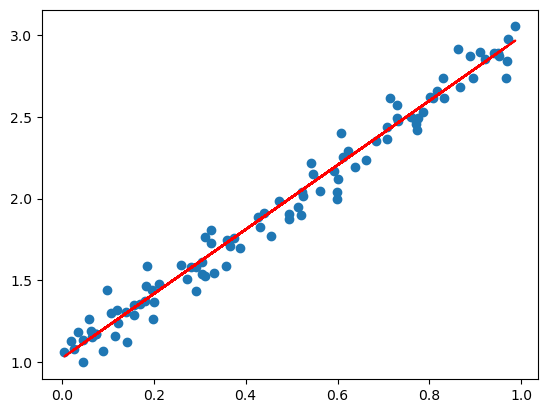

In [14]:
# Plot line of regression
# Remember that we never converted 'x' to a tensor (we only converted x_train to a tensor) and so we need to.
# To plot using matplotlib we need to make them np arrays again using the "detach" function

prediction_on_x = model(torch.from_numpy(x).float().to(device)) # computes the predicted values

plt.scatter(x,y) # plots the data
plt.plot(x,prediction_on_x.detach().numpy(),c='r') # plots the regression line
plt.show() # shows the plot

### Loss curve

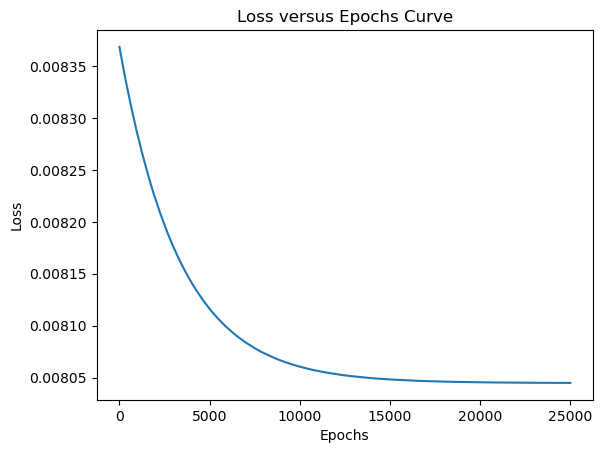

In [15]:
plt.plot(losses) # plots the losses
plt.xlabel('Epochs') # labels the x-axis
plt.ylabel('Loss') # labels the y-axis
plt.title('Loss versus Epochs Curve') # titles the plot
plt.show() # shows the plot